<a href="https://colab.research.google.com/github/samanthajmichael/deep_learning/blob/main/notebooks/Lab10_Adv_RNN_Michael_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Advanced RNNs
###  **DSBA 6165: AI & Deep Learning**


## Goal

The goal of this lab activity is modern RNN architectures. We practice to build LSTM variants and then apply to text data.

Let us first import the libraries we are going to use. TensorFlow for DL models, matplotlib and seaborn for plotting data/results, numpy and pandas for data handling. This time, to shorten the code, we directly import more keras models and tools.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.datasets import imdb # IMDB dataset is included in Keras

from keras.models import Sequential  # Model type to be used
from keras.layers import Dense, Dropout, Activation # Types of layers to be used in our model
#from keras.utils import np_utils                         # NumPy related tools
#from keras.utils.np_utils import to_categorical          # Converts a class vector (integers) to binary class matrix.
from tensorflow.keras import regularizers

print("TF version:", tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import random                        # for generating random numbers
import string

%matplotlib inline

TF version: 2.18.0


In [2]:
def plot_learning(history):
    tgts = ['loss', 'accuracy']
    vtgts = ['val_loss', 'val_accuracy']

    for tgt, val_tgt in zip(tgts, vtgts):
      plt.figure()
      plt.plot(history.history[tgt], label=tgt)
      plt.plot(history.history[val_tgt], label=val_tgt)
      plt.xlabel('Epoch')
      #plt.ylabel(ylab)
      plt.legend()
      plt.title(f"Training and validation {tgt}")

## Data

Let us first review the data preparation before applying advanced RNN structures to it.

### Preparing text data

Deep learning models, being differentiable functions, can only process numeric tensors: they can’t take raw text as input. Vectorizing text is the process of transforming text into numeric tensors. Text vectorization processes come in many shapes and forms, but they all follow the same template:

1.   First, you standardize the text to make it easier to process, such as by converting it to lowercase or removing punctuation.
2.   You split the text into units (called tokens), such as characters, words, or groups of words. This is called tokenization.
3.   You convert each such token into a numerical vector. This will usually involve first indexing all tokens present in the data.

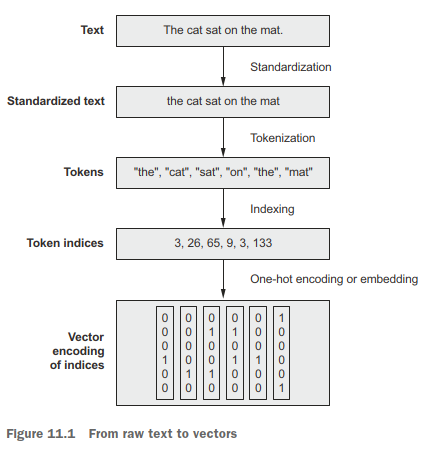

This function summarizes all the steps required for text vectorization.

In [3]:
# Using the TextVectorization layer
class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()

    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]

    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)

vectorizer = Vectorizer()
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
vectorizer.make_vocabulary(dataset)

It does the job.

In [4]:
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)

[2, 3, 5, 7, 1, 5, 6]


You can also decode the sentence to get the original text.

In [5]:
decoded_sentence = vectorizer.decode(encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


However, using something like this wouldn’t be very performant. In practice, you’ll work with the Keras TextVectorization layer, which is fast and efficient and can be dropped directly into a tf.data pipeline or a Keras model. This is what the TextVectorization layer looks like:

### TODO 1
1. Import `TextVectorization` from `tensorflow.keras.layers` [For a better understanding, click on this link.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)
1. Create a variable called `text_vectorization`  and initialise the imported`TextVectorization` and set the `output_mode` parameter to "int"



In [6]:
# TODO
# Configures the layer to return sequences of words encoded as integer indices. There are several other output modes
# available, which you will see in action in a bit.
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(output_mode='int')



Once you add the `TextVectorization` layer, internally it will operate the process as above and below.

In [7]:
" ".join(dataset)

'I write, erase, rewrite Erase again, and then A poppy blooms.'

In this case, " ".join(dataset) concatenates all of the strings in the dataset list into a single long string with spaces between them.

Now we have to convert raw text into a numerical format for that we have to adapt a `TextVectorization` layer in TensorFlow to a dataset of text examples, by building a vocabulary and setting configuration parameters based on the data. This involves building a vocabulary of words based on the data, and configuring the layer to tokenize and preprocess the input text
### TODO 1.1
1. Now  concatenate all of the strings in the `dataset` list into a single long string with **spaces**(" ") between them Using `join` method then split it into a list of individual words using `split()` method.
1. The list of these words is passed as an argument to the `adapt()` method of the layer called `text_vectorization`.
    1. Hint: To concatenate refer to the above code cell.

In [8]:
# TODO
text_vectorization.adapt(" ".join(dataset).split())

In [9]:
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 np.str_('erase'),
 np.str_('write'),
 np.str_('then'),
 np.str_('rewrite'),
 np.str_('poppy'),
 np.str_('i'),
 np.str_('blooms'),
 np.str_('and'),
 np.str_('again'),
 np.str_('a')]

### TODO 1.2
1. Now lets use the `text_vectorization` layer to transform `test_sentence` into an integer-encoded sequence.

In [10]:
# TODO
text_vectorization(test_sentence)

<tf.Tensor: shape=(7,), dtype=int64, numpy=array([ 7,  3,  5,  9,  1,  5, 10])>

By default, the `TextVectorization` layer will use the setting “convert to lowercase and remove punctuation” for text standardization, and “split on whitespace” for tokenization. But importantly, you can provide custom functions for standardization and tokenization, which means the layer is flexible enough to handle any use case.

## Intro to NLP

### Two approaches for representing groups of words: Sets and sequences

How a machine learning model should represent individual words is a relatively uncontroversial question: they’re categorical features (values from a predefined set), and we know how to handle those. They should be encoded as dimensions in a feature space, or as category vectors (word vectors in this case). A much more problematic question, however, is how to encode the way words are woven into sentences: word order.

The problem of order in natural language is an interesting one: unlike the steps of a timeseries, words in a sentence don’t have a natural, canonical order. Different languages order similar words in very different ways. For instance, the sentence structure of English is quite different from that of Japanese. Even within a given language, you can typically say the same thing in different ways by reshuffling the words a bit. Even further, if you fully randomize the words in a short sentence, you can still largely figure out what it was saying—though in many cases significant ambiguity seems to arise. Order is clearly important, but its relationship to meaning isn’t straightforward.

How to represent word order is the pivotal question from which different kinds of NLP architectures spring. The simplest thing you could do is just discard order and treat text as an unordered set of words—this gives you bag-of-words models. You could also decide that words should be processed strictly in the order in which they appear, one at a time, like steps in a timeseries—you could then leverage the recurrent models from the last chapter. Finally, a hybrid approach is also possible: the Transformer architecture is technically order-agnostic, yet it injects word-position information into the representations it processes, which enables it to simultaneously look at different parts of a sentence (unlike RNNs) while still being order-aware.

Because they take into account word order, both RNNs and Transformers are called sequence models. Historically, most early applications of machine learning to NLP just involved bag-of-words models. Interest in sequence models only started rising in 2015, with the rebirth of recurrent neural networks. Today, both approaches remain relevant. Let’s see how they work, and when to leverage which.

## Preparing the IMDB movie reviews data

## **Data Exploration**

Let’s start by downloading the dataset from the Stanford page of Andrew Maas and
uncompressing it:

### TODO 2
These two lines of code are downloading and extracting a dataset called "aclImdb_v1" from a website hosted by Stanford University.

Dataset link : https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
1. Using `!curl` command download a compressed file from the above link, and give option as `-O`
[Refer to this link for curl usage](https://www.geeksforgeeks.org/curl-command-in-linux-with-examples/).

    1. -O: saves the downloaded file on the local machine with the name provided in the parameters.
    



1. Using `!tar` command extract the `aclImdb_v1.tar.gz` and give option as -xf [Refer to this link for tar usage and extraction](https://www.cyberciti.biz/faq/tar-extract-linux/)

In [11]:
# TODO
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  8189k      0  0:00:10  0:00:10 --:--:-- 7414k


In [12]:
!tar -xf aclImdb_v1.tar.gz

You’re left with a directory named `aclImdb`, with the following structure.

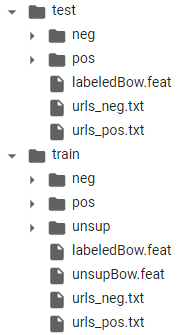

For instance, the train/pos/ directory contains a set of 12,500 text files, each of which contains the text body of a positive-sentiment movie review to be used as training data. The negative-sentiment reviews live in the “neg” directories. In total, there are 25,000 text files for training and another 25,000 for testing. There’s also a train/unsup subdirectory in there, which we don’t need. Let’s delete it:

In [13]:
!rm -r aclImdb/train/unsup

Take a look at the content of a few of these text files. Whether you’re working with text data or image data, remember to always inspect what your data looks like before you dive into modeling it. It will ground your intuition about what your model is actually doing:

In [14]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

## **Data Loading**

Next, let’s prepare a validation set by setting apart 20% of the training text files in a new directory, aclImdb/val:

In [15]:
import os, pathlib, shutil, random

batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)                # Shuffle the list of training files using a seed, to ensure we get
                                                      # the same validation set every time we run the code.
    num_val_samples = int(0.2 * len(files))           # Take 20% of the training files to use for validation.
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,     # Move the files to aclImdb/val/neg and aclImdb/val/pos.
                    val_dir / category / fname)

Let’s create three Dataset objects for training, validation, and testing using [`text_data_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/text_dataset_from_directory):

### TODO 3
1. Create three datasets `train_ds`, `val_ds`, and `test_ds` using `keras.utils.text_dataset_from_directory`[Refer to this link](https://www.tensorflow.org/api_docs/python/tf/keras/utils/text_dataset_from_directory) keeping `batch_size` as 32.
      1. Hint: We only give two arguments "path to dataset" and `batch_size`

In [16]:
# TODO
from tensorflow import keras
batch_size = 32

train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size
    )
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/val',
    batch_size=batch_size
    )
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
    )

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [17]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

These datasets yield inputs that are TensorFlow tf.string tensors and targets that are int32 tensors encoding the value “0” or “1.”

In [18]:
for inputs, targets in train_ds:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break


inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b"Ooof! This one was a stinker. It does not fall 'somewhere in between Star Wars and Thriller', thats for sure. In all actuality, it falls somewhere between the cracks of a Wham! video and Captain EO, only with not as big of a budget, and a lot more close ups of ugly teenagers crying. Simon Le Bon preens front and center, while the rest of the band gamely tries to hide the fact that they stole their whole career from Roxy Music's last 3 albums. Brief clips from Barbarella add nothing. Avoid at all costs. (However, I liked the part when they played 'Hungry Like The Wolf' but why was there a tiger lurking in the audience changing into a woman painted with tiger stripes? I mean, they aren't singing 'Eye of the Tiger' or 'Hungry like the Tiger' it's a Wolf! Whatever.) A DVD of Duran Duran's '80s videos is probably worth a look for nostalgia's sake", shape=(), dtype=

All set. Now let’s try learning something from this data.

### Processing words as a set: The bag-of-words approach

The simplest way to encode a piece of text for processing by a machine learning
model is to discard order and treat it as a set (a “bag”) of tokens. You could either look at individual words (unigrams) or try to recover some local order information by looking at groups of consecutive token (N-grams).

If you use a bag of single words, the sentence “the cat sat on the mat” becomes

image.png

The main advantage of this encoding is that you can represent an entire text as a single vector, where each entry is a presence indicator for a given word. For instance, using binary encoding (multi-hot), you’d encode a text as a vector with as many dimensions as there are words in your vocabulary—with 0s almost everywhere and some 1s for dimensions that encode words present in the text. Let’s try this on our task.

## **Data Preparation**

First, let’s process our raw text datasets with a `TextVectorization` layer so that they yield multi-hot encoded binary word vectors. Our layer will only look at single words (that is to say, unigrams).

### TODO 4
1. Declare a variable called `max_tokens` and limit the vocabulary size to 10000 most frequent words
1. Now just like TODO 1 Create a variable called `text_vectorization`  and initialise the imported`TextVectorization` and set the `output_mode` parameter to "multi_hot" and give aditional argument `max_tokens` as "max_tokens"
1. creates a new dataset `text_only_train_ds` that includes only the text input data from the `train_ds` dataset.Use the `map()` method and a `lambda` function that takes two arguments x and y, representing the text review and the corresponding label, respectively, and returns only x(i.e `y: x`)."
    1. Hint:The `lambda` function is used to select only the input data "x" and ignore the labels y.
       1. **explanation**:In the context of the map( ) method, x represents the input data (text reviews) and y represents the corresponding labels (positive or negative sentiment).
1. Using `adapt` adapt the `text_vectorization`  layer to the vocabulary of the `text_only_train_ds` dataset.

In [19]:
# TODO
# Limit the vocabulary to the 10,000 most frequent words. Otherwise we’d be
# indexing every word in the training data.
# This is a reasonable choice, since the average review length
# is 233 words, and only 5% of reviews are longer than 600 words.
max_tokens = 10000
text_vectorization = TextVectorization(output_mode="multi_hot", max_tokens=max_tokens)

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

Now lets prepare processed versions of the training, validation, and test datasets by applying a text vectorization step to the raw text inputs, which were obtained from the train_ds, val_ds, and test_ds datasets.

In [20]:
binary_1gram_train_ds = train_ds.map(               # Prepare processed versions of our training, validation, and test dataset.
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)                           # Make sure to specify num_parallel_calls to leverage multiple CPU cores.
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [21]:
binary_1gram_train_ds

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 10000), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Here we can understand the structure and format of the data

In [22]:
for inputs, targets in binary_1gram_train_ds:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

inputs.shape: (32, 10000)
inputs.dtype: <dtype: 'int64'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1 1 1 ... 0 0 0], shape=(10000,), dtype=int64)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


### Bigrams with TF-IDF Encoding

You can also add a bit more information to this representation by counting how many times each word or N-gram occurs, that is to say, by taking the histogram of the words over the text:

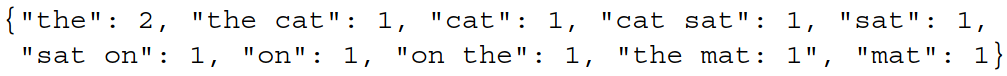

If you’re doing text classification, knowing how many times a word occurs in a sample is critical: any sufficiently long movie review may contain the word “terrible” regardless of sentiment, but a review that contains many instances of the word “terrible” is likely a negative one. Here’s how you’d count bigram occurrences with the TextVectorization layer.

### TODO 5
1. Now just like TODO 1 and TODO 4 Create a variable called `text_vectorization`  and initialise the imported`TextVectorization` set the `output_mode` parameter to "count" and give two additional arguments `max_tokens` as 10000 and `ngrams` as 2.

In [23]:
text_vectorization = TextVectorization(output_mode="count", max_tokens=10000, ngrams=2)

Now, of course, some words are bound to occur more often than others no matter
what the text is about. The words “the,” “a,” “is,” and “are” will always dominate your word count histograms, drowning out other words—despite being pretty much useless features in a classification context. How could we address this?

You already guessed it: via normalization. We could just normalize word counts by subtracting the mean and dividing by the variance (computed across the entire training dataset). That would make sense. Except most vectorized sentences consist almost entirely of zeros (our previous example features 12 non-zero entries and 19,988 zero entries), a property called “sparsity.” That’s a great property to have, as it dramatically reduces compute load and reduces the risk of overfitting. If we subtracted the mean from each feature, we’d wreck sparsity. Thus, whatever normalization scheme we use should be divide-only. What, then, should we use as the denominator? The best practice is to go with something called TF-IDF normalization—TF-IDF stands for “term frequency, inverse document frequency.”

### TODO 6

1. TF-IDF is so common that it’s built into the TextVectorization layer. Follow the TODO5 and just switch the `output_mode` argument to "tf_idf" while rest remains the same.

In [24]:
text_vectorization = TextVectorization(output_mode="tf_idf", max_tokens=10000, ngrams=2)

Let’s train a new model with this scheme.

### TODO 7
1. Just like TODO 4 Using `adapt` adapt the `text_vectorization`  layer to the vocabulary of the `text_only_train_ds` dataset.
1. Now lets create a  processed versions of the training, validation, and test datasets using text vectorization
     1.  Create a new varaible `tfidf_2gram_train_ds` where it use `map` method to `train_ds` dataset and applies a lambda function to each element of train_ds, which takes the review text "x" and the corresponding label "y", vectorizes the text using the `text_vectorization`, now add another argument that should take `num_parallel_calls` as 4.
     1. Do same thing for `tfidf_2gram_val_ds` with validation dataset `val_ds`
     1. and same thing for `tfidf_2gram_test_ds` with test dataset `test_ds`

In [25]:
# TODO
text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

### TODO 8
Now lets create an lstm model.
1. Declare two variables `hidden_units` and `EMBEDDING_DIM` where the number of hidden units are 16 in the LSTM layer and the dimensionality of the embedding layer is 128.
1. Define a function called `prepare_lstm`
    1. Create a variable called model initialise with `keras.Sequential()`
    * The model includes an embedding layer, an LSTM layer, and a dense output layer with a sigmoid activation function.
    2. In the embedding layer(`layers.Embedding`) the `input_dim` of the embedding layer is set to `max_tokens+1` and `output_dim` is set to `EMBEDDING_DIM`
    3. The LSTM layer has `hidden_units` as number of units(which we defined above)
    4. The dense layer has one unit with a "sigmoid" `activation` function and `name` the layer as "output"
    5. End the function by returning the model as `return` model
1. creates an instance of the LSTM model by calling the `prepare_lstm()` function into `lstm` variable.
1. Using `compile`, prepare your model to have "rmsprop" as an `optimizer`, have a `loss` function to be "binary_crossentropy" and `metrics` as "accuracy".

In [26]:
# TODO
hidden_units = 16
EMBEDDING_DIM = 128

def prepare_lstm():
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=max_tokens+1, output_dim=EMBEDDING_DIM))
    model.add(layers.LSTM(hidden_units))
    model.add(layers.Dense(1, activation="sigmoid", name="output"))
    # Build the model with a sample input
    model.build((None, 1))
    return model

lstm = prepare_lstm()
lstm.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1, 128)              │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16)                  │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,289,425 (4.92 MB)

 Trainable params: 1,289,425 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

### TODO 9
1. Create a variable as `callbacks` and using `keras.callbacks.ModelCheckpoint` and `save the best` model weights.
  * Save weights in .keras format in filepath
1. Create a variable called `history`. Using `lstm.fit`, train the `tfidf_2gram_train_ds.cache()`, `validation_data` as `tfidf_2gram_val_ds.cache()` , with 10 `epochs`, and `callbacks` as callbacks

In [27]:
# TODO
callbacks = [keras.callbacks.ModelCheckpoint("best_lstm_model.keras", save_best_only=True)]
history = lstm.fit(tfidf_2gram_train_ds.cache(), validation_data=tfidf_2gram_val_ds.cache(), epochs=10, callbacks=callbacks)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 169s 264ms/step - accuracy: 0.4987 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 165s 264ms/step - accuracy: 0.4975 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 165s 263ms/step - accuracy: 0.4944 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 165s 263ms/step - accuracy: 0.4969 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 165s 263ms/step - accuracy: 0.4954 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 165s 264ms/step - accuracy: 0.4965 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 164s 263ms/step - accuracy: 0.4961 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 164s 263ms/step - accuracy: 0.4978 -

### TODO 10
1. Load the model using `keras.models.load_model()` in a new variable called `model`.
2. Evaluate your model using `test_model.evaluate` on `tfidf_2gram_test_ds` it should returns the test loss and accuracy of the model
    1. Hint: To match the output as given below use the string format By indexing [1], we are selecting the accuracy metric from the tuple, which is then formatted with 3 decimal places (`[1]:.3f`) and printed out as part of the string

In [28]:
# TODO
model = keras.models.load_model("best_lstm_model.keras")
results = model.evaluate(tfidf_2gram_test_ds)
print(f"Test acc: {results[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 88s 112ms/step - accuracy: 0.4992 - loss: 0.6932
Test acc: 0.500


### TODO 11

1. Now plot the `history` using the `plot learning` function, which is defined at the top of this module.

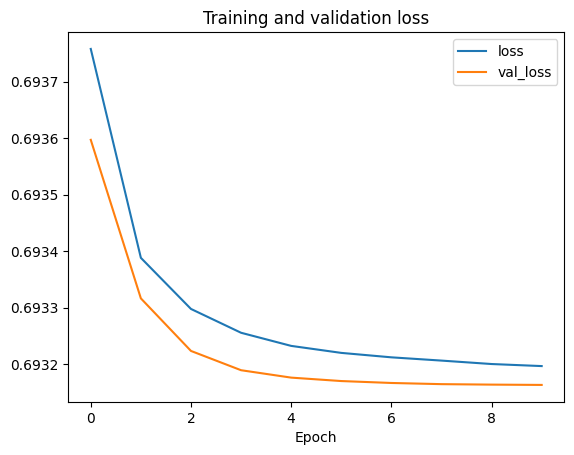

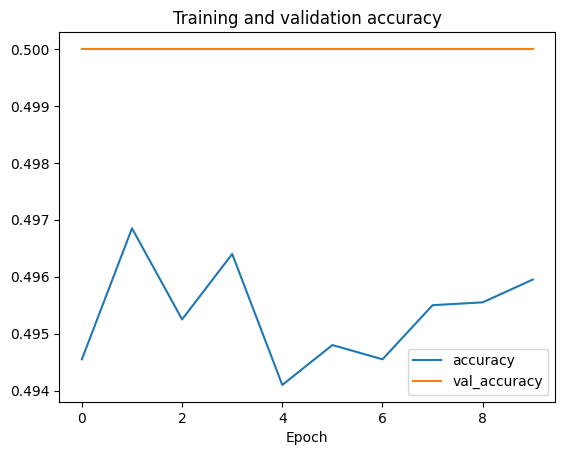

In [29]:
# TODO
plot_learning(history)

Well, this is not great with TF-IDF + simple LSTM solution here. Instead of making this model work better, let us use Bidirectional LSTM directly to the integer sequence.   

## Bidirectional LSTM

### TODO 12
1. Create a variable called `max_length` and set the maximum length of input text to 600 words.
1. Declare a variable called `max_tokens` and limit the vocabulary size to 10000 most frequent words
1. Creates a `text_vectorization` layer that will convert the raw text data to integer sequences.`max_tokens` as `max_tokens` The `output mode` is set to "int". `output_sequence_length` is set to `max_length`.
    1. Hint: This is same as TODO1 and TODO4
1. Using `adapt` adapt the `text_vectorization`  layer to the vocabulary of the `text_only_train_ds` dataset.
1. Now lets create a processed versions of the training, validation, and test datasets using text vectorization you can refer to TODO 8 for this section .
    1. create three variables named `int_train_ds`,`int_val_ds` and `int_test_ds` and repeat the mapping, vectorization, and num parallel calls process described in TODO7.


In [30]:
# TODO
# Preparing integer sequence datasets
max_length = 600
max_tokens = 10000
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length)

text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Next, let’s make a model. The simplest way to convert our integer sequences to vector sequences is to one-hot encode the integers (each dimension would represent one possible term in the vocabulary). On top of these one-hot vectors, we’ll add a simple bidirectional LSTM.



**Using the output of a previous time step of a Long Short-Term Memory (LSTM) neural network as an input for the next time step is something we learned in lab 8 TODO5.**
### TODO 13
1. Create a variable called `inputs` and define the input shape of the model Using `keras.Input` with shape of `shape=(None,)` and `dtype` as "int64"
1. Create a variable called `embedded` which encodes the input sequence of integers as one-hot vectors. Use `tf.one_hot` function give `inputs` as an argument and additional argument as `depth` which is equal to `max_tokens`
1. Make a variable called `x` , which has `layers.Bidirectional` wrapper applies the LSTM layer `layers.LSTM` with `32` neurons and `return_sequences`=`True`.which now receives input as previous output `embedded`
1. Make another variable called `x` , which has `layers.Bidirectional` wrapper applies the LSTM layer `layers.LSTM` with `32` neurons.which now receives input as previous output `x`
1. Apply the dropout regularization to the output of the previous LSTM layer `x`.Sets dropout rate to `0.5`.
1. creat a `outputs` variable having Another Dense() layer is created with a single neuron and a `sigmoid` activation function. This layer is applied to the output of the previous layer `x`.
1.  creat a `model` variable using `keras.Model` It takes the input tensor `inputs` and the output tensor `outputs` as arguments.
1. Finally Lets compile the model , Using `model.compile`, prepare your model to have "rmsprop" as an `optimizer`, have a `loss` function to be "binary_crossentropy" also it should take `metrics` as "accuracy".
1. print the `model` summary.

In [45]:
# TODO
# A sequence model built on one-hot encoded vector sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# A sequence model using Embedding instead of one-hot encoding
inputs = keras.Input(shape=(None,), dtype="int64")
# Replace Lambda with Embedding
embedded = layers.Embedding(input_dim=max_tokens, output_dim=max_tokens, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(embedded)
x = layers.Bidirectional(layers.LSTM(32))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 10000)    │    100,000,000 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, None)           │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_8           │ (None, None, 64)       │      2,568,448 │ embedding_2[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_9           │ (None, 64)             │         24,832 │ bidirectional_8[0][0], │
│ (Bidirectional)           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ bidirectional_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             65 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 102,593,345 (391.36 MB)

 Trainable params: 102,593,345 (391.36 MB)

 Non-trainable params: 0 (0.00 B)

Now, let’s train our model.

### TODO 14
1. Create a variable as `callbacks` and using `keras.callbacks.ModelCheckpoint` and `save the best` model weights.
  * Save weights in .keras format in filepath
1. Create a variable called `history` , Using `model.fit`, train the `int_train_ds`, `validation_data` as `int_val_ds` , with 10 `epochs`, and `callbacks` as callbacks
1. Load the model using `keras.models.load_model()` in a new variable called model.
2. Evaluate your model using `model.evaluate` on `int_test_ds` it should returns the test loss and accuracy of the model

In [46]:
# TODO
# Training a first basic sequence model
callbacks = [keras.callbacks.ModelCheckpoint("best_bidirectional_model.keras", save_best_only=True)]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 106ms/step - accuracy: 0.6833 - loss: 0.5859 - val_accuracy: 0.8036 - val_loss: 0.4274
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.8443 - loss: 0.3622 - val_accuracy: 0.8724 - val_loss: 0.3022
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 100ms/step - accuracy: 0.9030 - loss: 0.2463 - val_accuracy: 0.8584 - val_loss: 0.3403
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 100ms/step - accuracy: 0.9336 - loss: 0.1721 - val_accuracy: 0.8754 - val_loss: 0.3395
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 100ms/step - accuracy: 0.9598 - loss: 0.1155 - val_accuracy: 0.8720 - val_loss: 0.3658
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 100ms/step - accuracy: 0.9753 - loss: 0.0724 - val_accuracy: 0.8768 - val_loss: 0.4717
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 100ms/step - accuracy: 0.9841 - loss: 0.0472 - val_accuracy: 0.8792 - val_loss: 0.5532
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 100ms/step - accuracy: 0.9908 - loss: 0

In [47]:
model = keras.models.load_model("best_bidirectional_model.keras", safe_mode=False)
results = model.evaluate(int_test_ds)
print(f"Test acc: {results[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.8749 - loss: 0.3022
Test acc: 0.874


A first observation: this model trains very slowly, especially compared to the light-weight model of the previous section. This is because our inputs are quite large: each input sample is encoded as a matrix of size (600, 10000) (600 words per sample, 20,000 possible words). That’s 12,000,000 floats for a single movie review. Our bidirectional LSTM has a lot of work to do. Second, the model only gets to 87% test accuracy—it doesn’t perform nearly as well as our (very fast) binary unigram model. Clearly, using one-hot encoding to turn words into vectors, which was the simplest thing we could do, wasn’t a great idea. There’s a better way: word embeddings.

### TODO 14.1
1. Now plot the `history` using the `plot learning` function, which is defined at the top of this module.

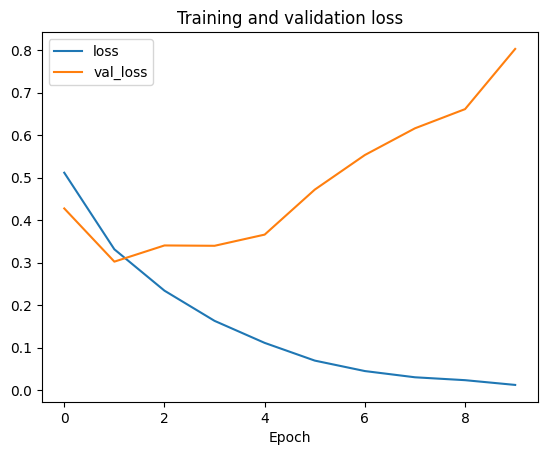

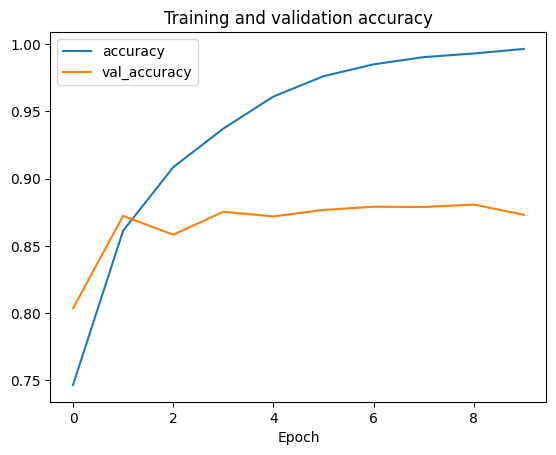

In [48]:
# TODO
plot_learning(history)